In [1]:
# imports 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.text import TSNEVisualizer
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

plt.style.use('ggplot')
rcParams['figure.figsize'] = (12,6)

#### Prepare

In [9]:
data_dir = 'data/'

In [10]:
# load data
lyrics = pd.read_csv(data_dir + 'clean_lyrics_df.csv', index_col='Unnamed: 0')
artist = pd.read_csv(data_dir + 'artists-data.csv')

lyrics['ALink'] = lyrics['ALink'].apply(lambda x: f'/{x.replace(" ","-")}/')

df = lyrics.merge(artist, left_on='ALink', right_on='Link')
df.drop(df[df['language']!='en'].index, inplace=True)
df.drop(['ALink','SLink','Link','language','features'], axis=1, inplace=True)
df.rename(columns={'SName': 'Title'}, inplace=True)
df.head()

,Title,Lyric,Artist,Genres,Songs,Popularity
0,In da Club,"go, go, go, go\ngo, go, go shawty\nit's your b...",50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
1,21 Questions,new york city!\nyou are now rapping...with 50 ...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
2,P.I.M.P.,i don't know what you heard about me\nbut a b*...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
3,Many Men (Wish Death),man we gotta go get something to eat man\ni'm ...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
4,Candy Shop,yeah...\nuh huh\nso seductive\ni'll take you t...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7


In [21]:
# Normalize popularity
df['PopNorm'] = (df['Popularity'] - df['Popularity'].min()) / (df['Popularity'].max() - df['Popularity'].min())
df['PopNorm'].describe()

count    13870.000000
mean         0.113020
std          0.198467
min          0.000000
25%          0.011314
50%          0.028721
75%          0.122715
max          1.000000
Name: PopNorm, dtype: float64

Convert 'Genres' to One-Hot encoding

In [28]:
vectorizer = CountVectorizer()

vectorizer.fit(df['Genres'].replace(';',''))
print('Vocabulary:', vectorizer.vocabulary_)

X = vectorizer.transform(df['Genres'])

Vocabulary: {'hip': 10, 'hop': 11, 'rap': 17, 'black': 0, 'music': 15, 'pop': 16, 'funk': 7, 'rockabilly': 19, 'romântico': 20, 'rock': 18, 'folk': 6, 'country': 3, 'blues': 1, 'dance': 4, 'soul': 21, 'disco': 5, 'hard': 8, 'heavy': 9, 'metal': 14, 'indie': 12, 'jazz': 13, 'clássico': 2, 'surf': 22}
Encoded Lyrics:
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


Clustering Genre Sets

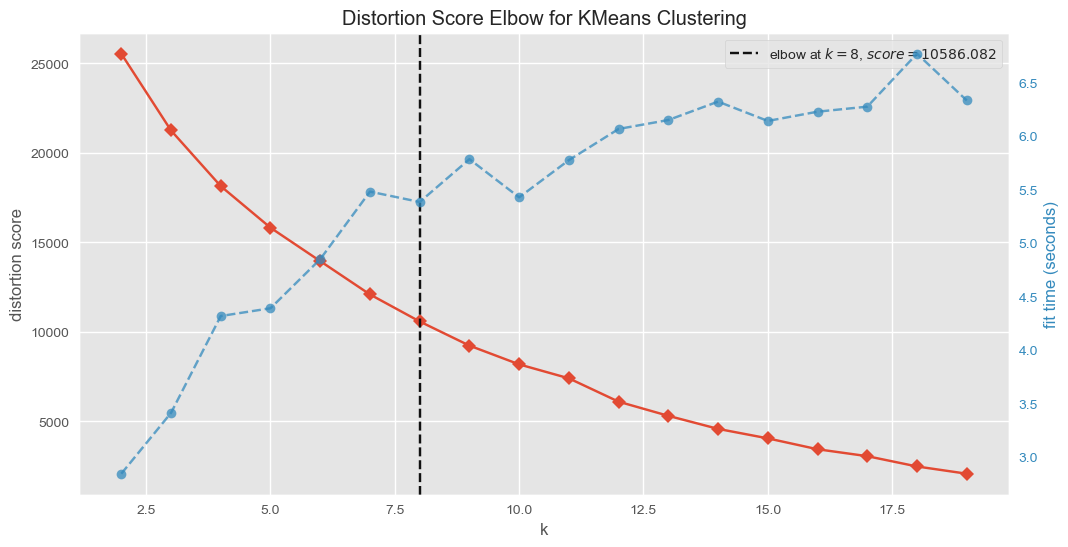

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
# Elbow score
import warnings
warnings.filterwarnings("ignore")

kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2,20))
visualizer.fit(X)
visualizer.show()

In [37]:
kmeans.n_clusters = visualizer.elbow_value_
kmeans.fit(X)

df['genre_cluster'] = kmeans.labels_

In [38]:
# Cluster distribution
df.groupby('genre_cluster')['genre_cluster'].count().sort_values(ascending=False)

genre_cluster
1    4199
3    1996
2    1956
4    1583
7    1220
0    1124
5    1102
6     690
Name: genre_cluster, dtype: int64

Clustering Lyrics

In [39]:
vectorizer = TfidfVectorizer(max_df=0.7)

vectorizer.fit(df['Lyric'])
V = vectorizer.vocabulary_
print('Vocabulary:', dict(zip(list(V.keys())[:20], list(V.values())[:20])))

X = vectorizer.transform(df['Lyric'])

Vocabulary: {'go': 17464, 'shawty': 36454, 'your': 46879, 'birthday': 4222, 'we': 45205, 'gon': 17565, 'party': 29752, 'like': 23892, 'sip': 37197, 'bacardi': 2890, 'yo': 46793, 'know': 22870, 'don': 12249, 'give': 17279, 'not': 28183, 'can': 6421, 'find': 15309, 'club': 8227, 'bottle': 5093, 'full': 16511}
Encoded Lyrics:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


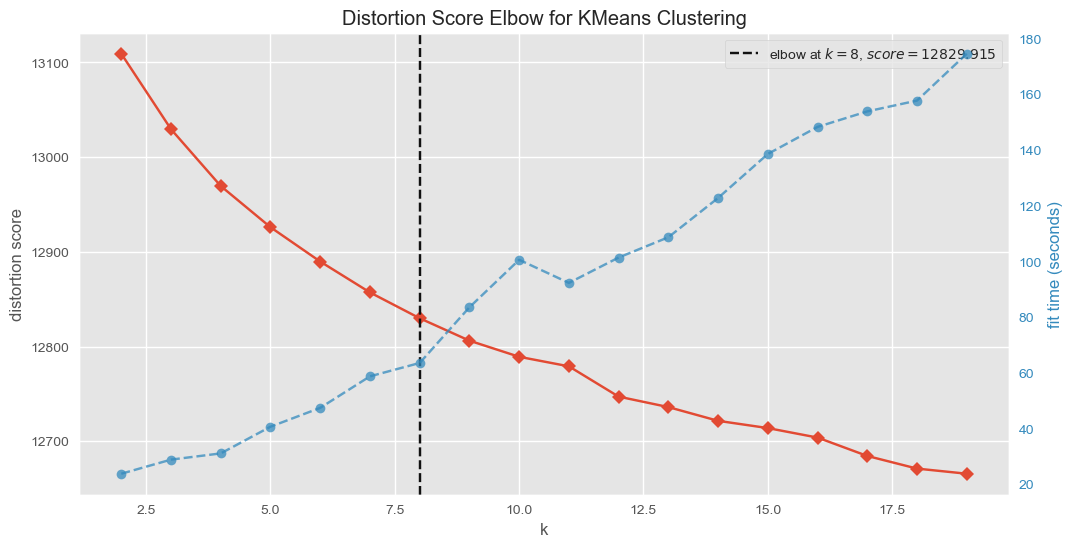

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
# Elbow score
import warnings
warnings.filterwarnings("ignore")

kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2,20))
visualizer.fit(X)
visualizer.show()

For n_clusters = 8, the average silhouette score is: 0.0033953431279476684
For n_clusters = 9, the average silhouette score is: 0.00410788392271026
For n_clusters = 10, the average silhouette score is: 0.0043495983783608146
For n_clusters = 11, the average silhouette score is: 0.003266790396965863
For n_clusters = 12, the average silhouette score is: 0.0053356553981713005
For n_clusters = 13, the average silhouette score is: 0.0051416611414778
For n_clusters = 14, the average silhouette score is: 0.004787913897686023
For n_clusters = 15, the average silhouette score is: 0.005524613082170178


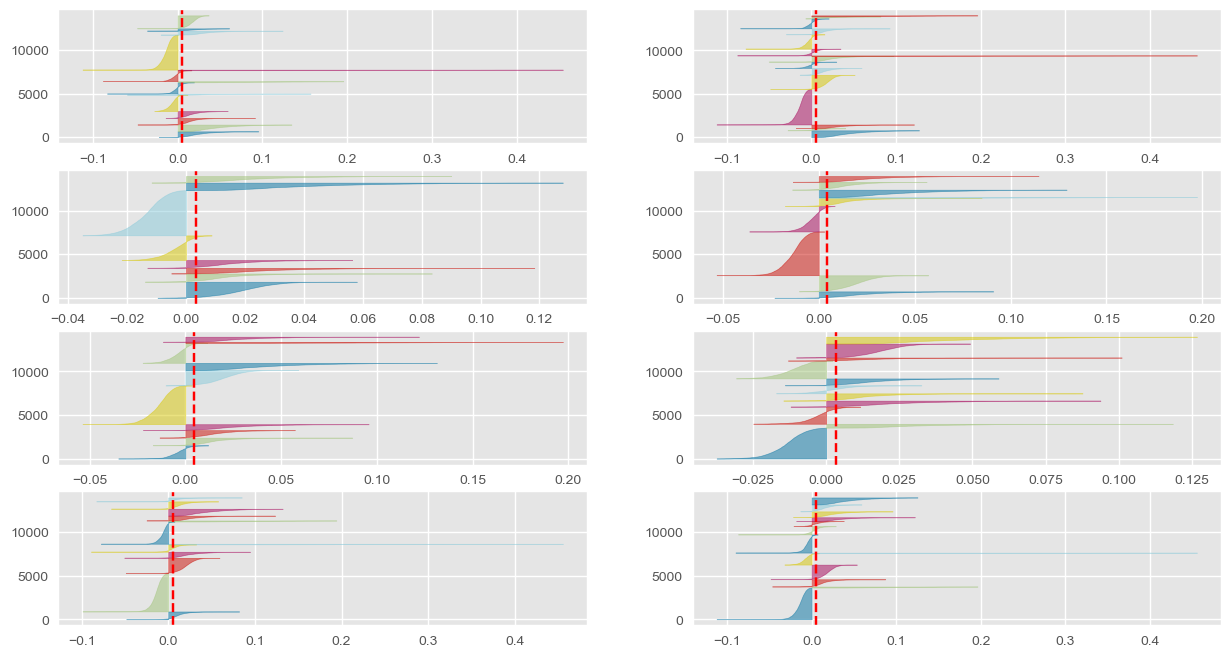

In [49]:
fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in range(8,16):
    '''
    Create KMeans instances for different number of clusters
    '''
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-7][mod])
    visualizer.fit(X)
    print(f'For n_clusters = {visualizer.n_clusters_}, the average silhouette score is: {visualizer.silhouette_score_}')

In [50]:
kmeans.n_clusters = visualizer.elbow_value_
kmeans.fit(X)

df['lyric_cluster'] = kmeans.labels_

Text(0.5, 0, 'Lyric Cluster')

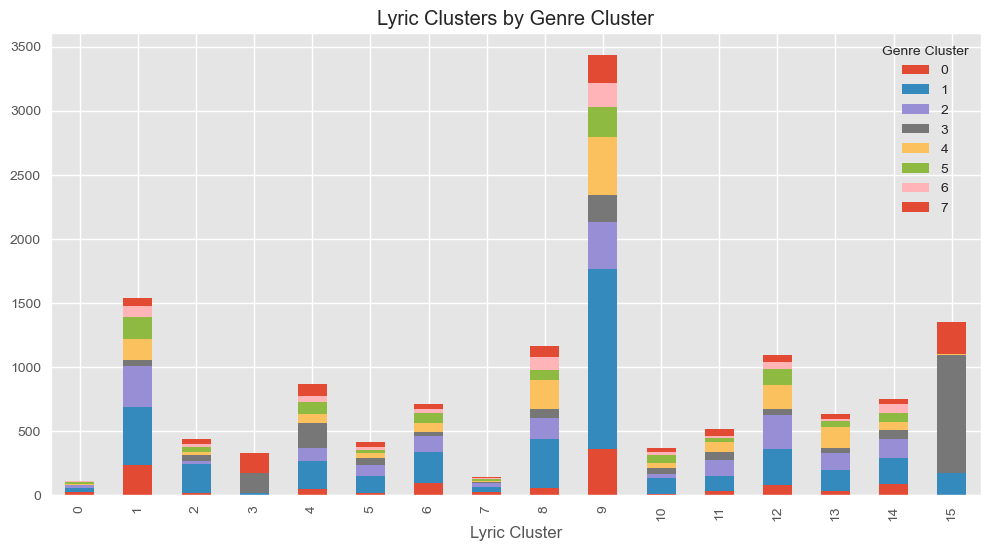

In [56]:
group = df.groupby(['lyric_cluster','genre_cluster'])['Title'].count().reset_index()
pivot = pd.pivot_table(data=group, index=['lyric_cluster'], columns=['genre_cluster'], values='Title')
pivot.plot.bar(stacked=True, title='Lyric Clusters by Genre Cluster')
plt.legend(title='Genre Cluster')
plt.xlabel('Lyric Cluster')

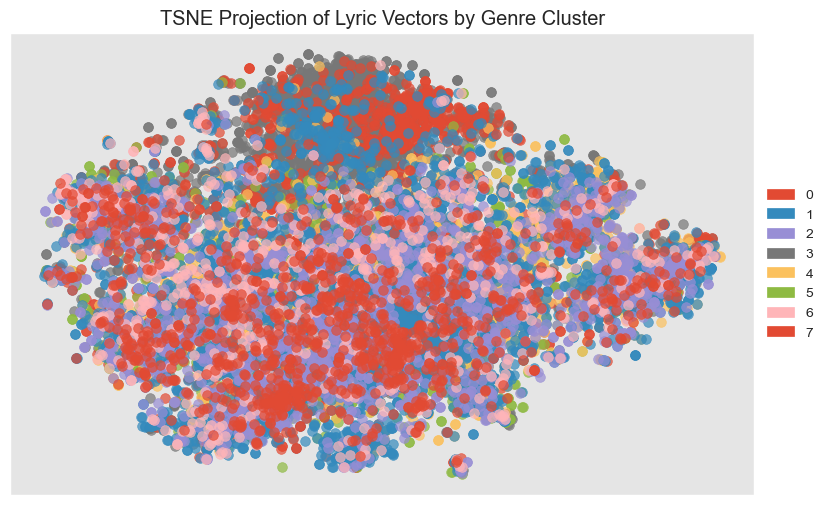

<AxesSubplot:title={'center':'TSNE Projection of Lyric Vectors by Genre Cluster'}>

In [163]:
tsne = TSNEVisualizer()
tsne.fit(X, df['genre_cluster'], title='TSNE')
tsne.title = 'TSNE Projection of Lyric Vectors by Genre Cluster'
tsne.show()